In [1]:
import os
import flopy
import matplotlib
import matplotlib.pyplot as plt
import flopy.utils.binaryfile as bf
import numpy as np

In [2]:
ws = '/home/harsh/Desktop/modflow_flopy/flopyCourse/Class04/ResultsCopy'
name = 'Ex04'
exe_name = '/home/harsh/Desktop/modflow_flopy/flopyCourse/mf6'
sim = flopy.mf6.MFSimulation.load(sim_name=name, exe_name=exe_name, sim_ws=ws) #loading the simulation from previous model

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package disv...
    loading package ic...
    loading package npf...
    loading package wel...
    loading package rch...
    loading package riv...
    loading package oc...
  loading ims package ex04...


In [3]:
wsa = 'Results' #alternative results folder for this simulation
sim.set_sim_path(wsa)
sim.write_simulation()
sim.run_simulation()

#created a copy of the model and run it

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ex04...
  writing model ex04...
    writing model name file...
    writing package disv...
    writing package ic...
    writing package npf...
    writing package wel_0...
    writing package rcha...
    writing package riv_0...
    writing package oc...
FloPy is using the following  executable to run the model: /home/harsh/Desktop/modflow_flopy/flopyCourse/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.2.1 02/18/2021

  MODFLOW 6 compiled May  4 2021 17:51:29 with GFORTRAN compiler (ver. 9.3.0)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
imp

(True, [])

In [5]:
#sim.model_names #gives model name in the simulation
gwf = sim.get_model('Ex04')

In [6]:
hpth = os.path.join(wsa, name+'.hds')
hobja = flopy.utils.HeadFile(hpth)
heada = hobja.get_data(totim=1000)

In [7]:
cpth = os.path.join(wsa, name+'.cbc')
cobja = flopy.utils.CellBudgetFile(cpth, precision=hobja.precision)
spda = cobja.get_data(text='DATA-SPDIS')[0]

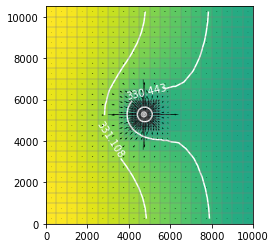

In [10]:
mm = flopy.plot.PlotMapView(model=gwf, layer=2)
v = mm.plot_array(heada)
mm.plot_specific_discharge(spda)
mm.plot_bc('RIV')
c = mm.contour_array(heada, colors='white')
plt.clabel(c)
mm.plot_grid(lw=0.2)

In [11]:
riv_data = gwf.riv_0.stress_period_data.array[0]
#riv_data #river information

rec.array([((0, 19), 320., 100000., 318.),
           ((0, 650), 320., 100000., 318.),
           ((0, 39), 320., 100000., 318.),
           ((0, 630), 320., 100000., 318.),
           ((0, 59), 320., 100000., 318.),
           ((0, 610), 320., 100000., 318.),
           ((0, 79), 320., 100000., 318.),
           ((0, 590), 320., 100000., 318.),
           ((0, 99), 320., 100000., 318.),
           ((0, 570), 320., 100000., 318.),
           ((0, 119), 320., 100000., 318.),
           ((0, 550), 320., 100000., 318.),
           ((0, 139), 320., 100000., 318.),
           ((0, 530), 320., 100000., 318.),
           ((0, 159), 320., 100000., 318.),
           ((0, 510), 320., 100000., 318.),
           ((0, 194), 320., 100000., 318.),
           ((0, 490), 320., 100000., 318.),
           ((0, 265), 320., 100000., 318.),
           ((0, 455), 320., 100000., 318.),
           ((0, 384), 320., 100000., 318.)],
          dtype=[('cellid', 'O'), ('stage', '<f8'), ('cond', '<f8'), ('rbot', '<

In [12]:
pakdata = flopy.mf6.ModflowGwfsfr.packagedata.empty(gwf,
                                                   maxbound=riv_data.shape[0]) #streamflow routing package

In [18]:
# pakdata.dtype.descr
for idx, (r,s) in enumerate(zip(riv_data, pakdata)):
    rl = 500 #river length
    rw = 10 #river width
    rt = 1 #river height
    if idx == 0 or idx+1 == riv_data.shape[0]:
        icon = 1
    else:
        icon = 2
    rk = r['cond'] * rt / (rl * rw)
    s['rno'] = idx
    s['cellid'] = r['cellid']
    s['rlen'] = rl
    s['rwid'] = rw
    s['rgrd'] = .1/rl
    s['rtp'] = r['rbot']
    s['rbth'] = rt
    s['rhk'] = rk
    s['man'] = 0.03
    s['ncon'] = icon
    s['ustrf'] = 1
    s['ndv'] = 0

In [19]:
iconn = []
for idx, s in enumerate(pakdata):
    iconnr = [idx]
    if idx > 0:
        iconnr.append(idx-1)
    if idx + 1 < pakdata.shape[0]:
        iconnr.append(-(idx+1))
    iconn.append(iconnr)

iconn

[[0, -1],
 [1, 0, -2],
 [2, 1, -3],
 [3, 2, -4],
 [4, 3, -5],
 [5, 4, -6],
 [6, 5, -7],
 [7, 6, -8],
 [8, 7, -9],
 [9, 8, -10],
 [10, 9, -11],
 [11, 10, -12],
 [12, 11, -13],
 [13, 12, -14],
 [14, 13, -15],
 [15, 14, -16],
 [16, 15, -17],
 [17, 16, -18],
 [18, 17, -19],
 [19, 18, -20],
 [20, 19]]

In [20]:
fstg = name + '.stage.bin'
unit_conversion = 1.486*86400
sfr = flopy.mf6.ModflowGwfsfr(gwf, stage_filerecord=fstg, unit_conversion=unit_conversion,
                             print_flows=True, print_stage=True,
                             nreaches=pakdata.shape[0], packagedata=pakdata,
                             connectiondata=iconn)

In [21]:
gwf.remove_package('RIV_0') #removing river package because no longer needed

In [22]:
gwf.package_names

['disv', 'ic', 'npf', 'wel_0', 'rcha', 'oc', 'sfr_0']

In [23]:
gwf.wel.stress_period_data.array[0]

rec.array([((2, 308), -150000., 0.)],
          dtype=[('cellid', 'O'), ('q', '<f8'), ('iface', '<f8')])

In [24]:
wel_data = gwf.wel.stress_period_data.array
wel_data

[rec.array([((2, 308), -150000., 0.)],
           dtype=[('cellid', 'O'), ('q', '<f8'), ('iface', '<f8')])]

In [25]:
pak_data = flopy.mf6.ModflowGwfmaw.packagedata.empty(model=gwf, maxbound=1)

In [26]:
pak_data

rec.array([(0, nan, nan, nan, None, 0)],
          dtype=[('wellno', '<i8'), ('radius', '<f8'), ('bottom', '<f8'), ('strt', '<f8'), ('condeqn', 'O'), ('ngwfnodes', '<i8')])

In [27]:
botm = gwf.dis.botm.array
top = gwf.dis.top.array

In [29]:
ncon_naw = 0
for iwel, pd in enumerate(pak_data):
    cellid = wel_data[0]['cellid'][iwel]
    print(cellid)
    pd['wellno'] = iwel
    pd['radius'] = 0.25
    pd['bottom'] = botm[cellid]
    pd['strt'] = top[cellid[1]]
    pd['condeqn'] = 'THIEM'
    pd['ngwfnodes'] = 1
    ncon_naw += 1
    
    

(2, 308)


In [30]:
mawcon_data = flopy.mf6.ModflowGwfmaw.connectiondata.empty(model=gwf, maxbound=ncon_naw)

In [33]:
for iwel, mc in enumerate(mawcon_data):
    cellid = wel_data[0]['cellid'][iwel]
    mc['wellno'] = iwel
    mc['icon'] = 0
    mc['cellid'] = cellid
    print(cellid)
    top = botm[(cellid[0]-1, cellid[1])]
    bot = botm[cellid]
    mc['scrn_top'] = top
    mc['scrn_bot'] = bot
    mc['hk_skin'] = -999
    mc['radius_skin'] = -999

(2, 308)


In [34]:
pd = []
for iwel, v in enumerate(wel_data):
    pd.append([iwel, 'RATE', v['q'][0]])
period_data = {0:pd}

In [35]:
maw = flopy.mf6.ModflowGwfmaw(gwf, print_head=True, nmawwells=1, packagedata=pak_data,
                             connectiondata=mawcon_data, perioddata=period_data)

In [36]:
gwf.remove_package('WEL')
sim.write_simulation()
sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ex04...
  writing model ex04...
    writing model name file...
    writing package disv...
    writing package ic...
    writing package npf...
    writing package rcha...
    writing package oc...
    writing package sfr_0...
    writing package maw_0...
FloPy is using the following  executable to run the model: /home/harsh/Desktop/modflow_flopy/flopyCourse/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.2.1 02/18/2021

  MODFLOW 6 compiled May  4 2021 17:51:29 with GFORTRAN compiler (ver. 9.3.0)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
imp

(True, [])

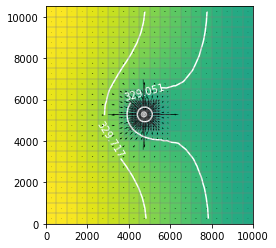

In [38]:
hpth = os.path.join(wsa, name+'.hds')
hobja = flopy.utils.HeadFile(hpth)
heada = hobja.get_data(totim=1000)

cpth = os.path.join(wsa, name+'.cbc')
cobja = flopy.utils.CellBudgetFile(cpth, precision=hobja.precision)
spda = cobja.get_data(text='DATA-SPDIS')[0]

mm = flopy.plot.PlotMapView(model=gwf, layer=2)
v = mm.plot_array(heada)
mm.plot_specific_discharge(spda)
# mm.plot_bc('RIV')
c = mm.contour_array(heada, colors='white')
plt.clabel(c)
mm.plot_grid(lw=0.2)